In [1]:
import numpy as np
import pandas as pd
from sympy import symbols, Function, Eq, dsolve

In [2]:
# Configuraciones iniciales
np.random.seed(42)  # Para reproducibilidad
g = 9.81  # Gravedad en m/s^2
num_samples = 5000  # Número de trayectorias

# Definir símbolos para sympy
t = symbols("t")  # Tiempo
vx, vy = Function("vx")(t), Function("vy")(t)  # Velocidades
m, c, g = symbols("m c g")  # Parámetros
x, y = symbols("x y")  # Posiciones

# Ecuaciones diferenciales
a_x = Eq(vx.diff(t), -(c / m) * vx)
a_y = Eq(vy.diff(t), -g - (c / m) * vy)

# Solución de las ecuaciones
sol_vx = dsolve(a_x)
sol_vy = dsolve(a_y)

# Generación de valores aleatorios
velocidades_iniciales = np.random.uniform(10, 100, num_samples)  # m/s
angulos = np.random.uniform(10, 80, num_samples)  # grados
masas = np.random.uniform(0.5, 10, num_samples)  # kg
constantes_resistencia = np.random.uniform(0.1, 1.0, num_samples)  # kg/m
# Convertir soluciones en funciones para evaluar
vx_func = sol_vx.rhs
vy_func = sol_vy.rhs

In [3]:
def calcular_trayectoria(v0, theta, m_val, c_val, dt=0.1, max_time=10):
    theta_rad = np.radians(theta)  # Convertir ángulo a radianes
    vx0 = v0 * np.cos(theta_rad)  # Velocidad inicial en x
    vy0 = v0 * np.sin(theta_rad)  # Velocidad inicial en y

    # Reemplazar constantes en sympy
    vx_t = vx_func.subs({c: c_val, m: m_val}).subs("C1", vx0)
    vy_t = vy_func.subs({c: c_val, m: m_val, g: 9.81}).subs("C1", vy0)

    # Calcular posiciones
    x, y = 0, 0
    trayectoria = []

    for t_val in np.arange(0, max_time, dt):
        vx_eval = vx_t.subs(t, t_val).evalf()
        vy_eval = vy_t.subs(t, t_val).evalf()

        x += vx_eval * dt
        y += vy_eval * dt
        trayectoria.append((x, y))

        # Detener si toca el suelo
        if y < 0:
            break
    return trayectoria

In [4]:
# Generación del dataset
data = []
for v0, theta, m_val, c_val in zip(
    velocidades_iniciales, angulos, masas, constantes_resistencia
):
    trayectoria = calcular_trayectoria(v0, theta, m_val, c_val)
    for punto in trayectoria:
        data.append([v0, theta, m_val, c_val, punto[0], punto[1]])
        if len(data) >= num_samples:
            break  # Detener cuando se alcance el número deseado de registros

# Convertir a DataFrame
columnas = [
    "velocidad_inicial",
    "angulo",
    "masa",
    "constante_resistencia",
    "pos_x",
    "pos_y",
]
datos = pd.DataFrame(data[:num_samples], columns=columnas)  # Asegurar 5000 registros

# Guardar en CSV
datos.to_csv("trayectorias_proyectil.csv", index=False)
print("Generación de datos completada. Guardado en 'trayectorias_proyectil.csv'.")


Generación de datos completada. Guardado en 'trayectorias_proyectil.csv'.


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
import matplotlib.pyplot as plt

# Cargar el dataset generado
datos = pd.read_csv("trayectorias_proyectil.csv")

# Separar características (X) y etiquetas (y)
X = datos[["velocidad_inicial", "angulo", "masa", "constante_resistencia"]].values
y = datos[["pos_x", "pos_y"]].values

# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ** Anterior
# Escalar los datos
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# ** anterior estaba 64 - 64
# Crear el modelo de red neuronal profunda
model = Sequential(
    [
        Dense(32, input_dim=4, activation="relu"),
        Dense(16, activation="relu", kernel_regularizer="l2"),
        Dense(2, activation="linear"),
    ]
)

# ** Anterior
# Compilar el modelo
# model.compile(
#    optimizer=Adam(learning_rate=0.001), loss="mean_squared_error", metrics=["mae"]
# )

model.compile(
    optimizer=RMSprop(learning_rate=0.001), loss="mean_squared_error", metrics=["mae"]
)

# model.add(Dropout(0.3))

# Entrenar el modelo
history = model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=1024,
    validation_data=(X_test, y_test),
    verbose=0,
)

# Evaluar el modelo
loss, mae = model.evaluate(X_test, y_test)
print(f"Pérdida (Loss): {loss:.4f}, Error Absoluto Medio (MAE): {mae:.4f}")

# Predicciones en el conjunto de prueba
predicciones = model.predict(X_test)

# Calcular métricas de regresión
mae_x = mean_absolute_error(y_test[:, 0], predicciones[:, 0])
mae_y = mean_absolute_error(y_test[:, 1], predicciones[:, 1])

mse_x = mean_squared_error(y_test[:, 0], predicciones[:, 0])
mse_y = mean_squared_error(y_test[:, 1], predicciones[:, 1])

r2_x = r2_score(y_test[:, 0], predicciones[:, 0])
r2_y = r2_score(y_test[:, 1], predicciones[:, 1])

print(f"MAE para pos_x: {mae_x:.4f}, MAE para pos_y: {mae_y:.4f}")
print(f"MSE para pos_x: {mse_x:.4f}, MSE para pos_y: {mse_y:.4f}")
print(f"R² para pos_x: {r2_x:.4f}, R² para pos_y: {r2_y:.4f}")


# Precisión personalizada: porcentaje de predicciones dentro de una tolerancia
def accuracy_within_tolerance(y_true, y_pred, tolerance=0.1):
    diff = np.abs(y_true - y_pred)
    within_tolerance = np.all(diff <= tolerance, axis=1)
    return np.mean(within_tolerance) * 100


accuracy = accuracy_within_tolerance(y_test, predicciones, tolerance=1.0)
print(f"Precisión dentro del rango de tolerancia (1.0 unidades): {accuracy:.2f}%")

# Visualizar las predicciones vs valores reales (pos_x y pos_y separadamente)
plt.figure(figsize=(12, 6))

# Comparar pos_x
plt.subplot(1, 2, 1)
plt.scatter(y_test[:, 0], predicciones[:, 0], alpha=0.5)
plt.title("Comparación de pos_x (Real vs Predicho)")
plt.xlabel("Real")
plt.ylabel("Predicho")
plt.grid(True)

# Comparar pos_y
plt.subplot(1, 2, 2)
plt.scatter(y_test[:, 1], predicciones[:, 1], alpha=0.5)
plt.title("Comparación de pos_y (Real vs Predicho)")
plt.xlabel("Real")
plt.ylabel("Predicho")
plt.grid(True)

plt.tight_layout()
plt.show()

# Curvas de aprendizaje
plt.figure(figsize=(10, 6))
plt.plot(history.history["loss"], label="Pérdida de Entrenamiento")
plt.plot(history.history["val_loss"], label="Pérdida de Validación")
plt.title("Curvas de Pérdida durante el Entrenamiento")
plt.xlabel("Épocas")
plt.ylabel("Pérdida (Loss)")
plt.legend()
plt.grid(True)
plt.show()

/home/mrtopo/Documents/Universidad/2024-2/inteligentesII/intelligent-II-neuronal-networks/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Error relativo promedio: 153.16%
Precisión del modelo: -53.16%


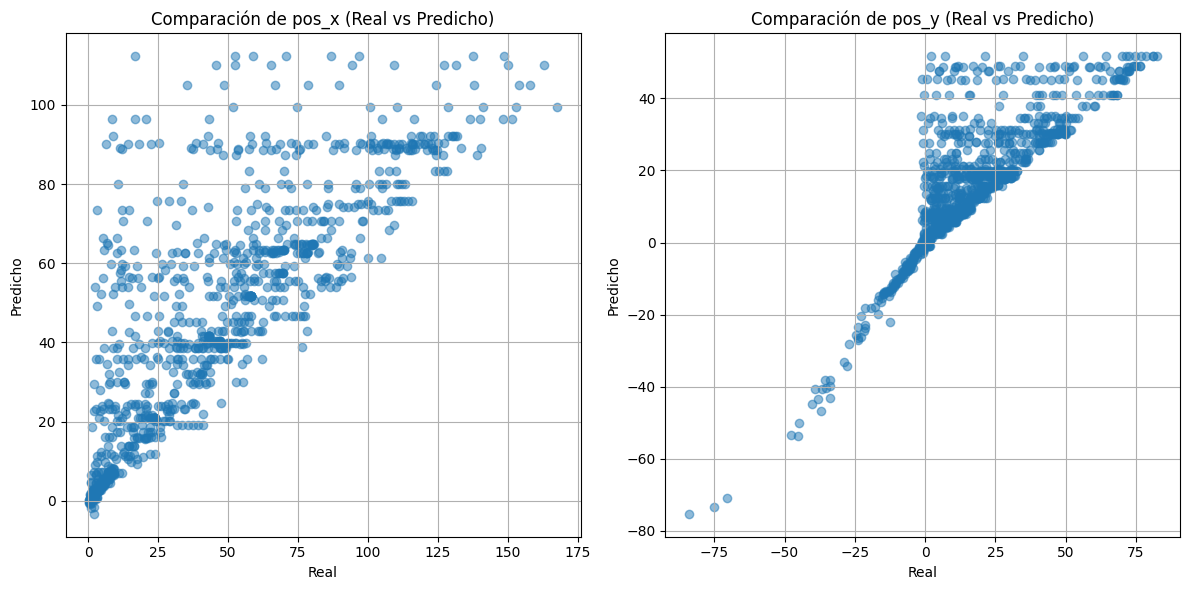

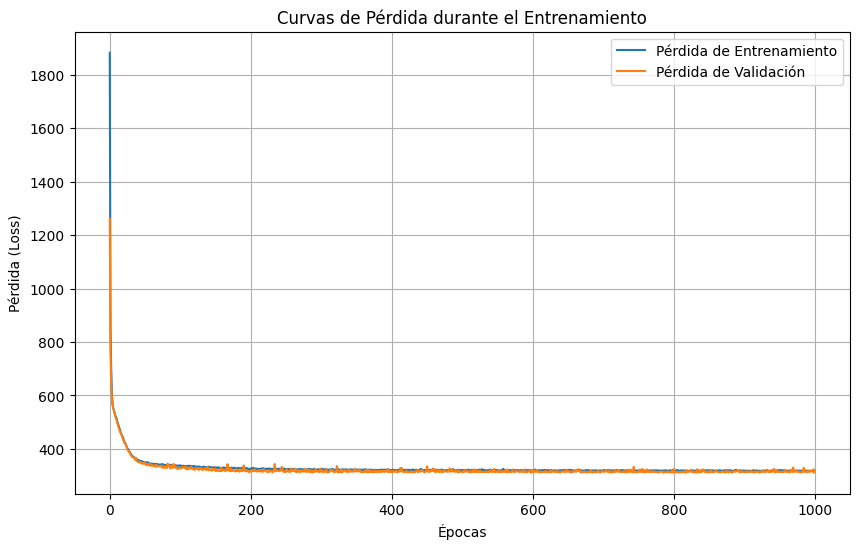

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Cargar el dataset
try:
    data = pd.read_csv("trayectorias_proyectil.csv")
except FileNotFoundError:
    print(
        "Archivo 'trayectorias_proyectil.csv' no encontrado. Verifica el nombre y la ubicación."
    )

# Verificar que data sea un DataFrame
if not isinstance(data, pd.DataFrame):
    raise TypeError(
        "El archivo cargado no es un DataFrame. Revisa el proceso de carga."
    )

# Separar características (X) y etiquetas (y)
X = data[["velocidad_inicial", "angulo", "masa", "constante_resistencia"]].values
y = data[["pos_x", "pos_y"]].values

# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Escalar los datos
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Crear el modelo
model = Sequential(
    [
        Dense(128, input_dim=4, activation="relu"),
        # Dropout(0.3),
        Dense(64, activation="relu"),
        # BatchNormalization(),
        Dense(32, activation="relu"),
        Dense(2, activation="linear"),
    ]
)

# Compilar el modelo
model.compile(
    optimizer=Adam(learning_rate=0.0005), loss="mean_squared_error", metrics=["mae"]
)

# Entrenar el modelo
history = model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=0,
)

# Evaluar el modelo en el conjunto de prueba
loss, mae = model.evaluate(X_test, y_test, verbose=0)

# Calcular precisión relativa
y_pred = model.predict(X_test)
relative_error = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
accuracy = 100 - relative_error

print(f"Error relativo promedio: {relative_error:.2f}%")
print(f"Precisión del modelo: {accuracy:.2f}%")


# Visualizar las predicciones vs valores reales (pos_x y pos_y separadamente)
plt.figure(figsize=(12, 6))

# Comparar pos_x
plt.subplot(1, 2, 1)
plt.scatter(y_test[:, 0], y_pred[:, 0], alpha=0.5)
plt.title("Comparación de pos_x (Real vs Predicho)")
plt.xlabel("Real")
plt.ylabel("Predicho")
plt.grid(True)

# Comparar pos_y
plt.subplot(1, 2, 2)
plt.scatter(y_test[:, 1], y_pred[:, 1], alpha=0.5)
plt.title("Comparación de pos_y (Real vs Predicho)")
plt.xlabel("Real")
plt.ylabel("Predicho")
plt.grid(True)

plt.tight_layout()
plt.show()

# Curvas de aprendizaje
plt.figure(figsize=(10, 6))
plt.plot(history.history["loss"], label="Pérdida de Entrenamiento")
plt.plot(history.history["val_loss"], label="Pérdida de Validación")
plt.title("Curvas de Pérdida durante el Entrenamiento")
plt.xlabel("Épocas")
plt.ylabel("Pérdida (Loss)")
plt.legend()
plt.grid(True)
plt.show()
